Objective:<br><br>
This analysis focuses on collecting data science job listings to understand what factors influence the salaries for data science career postings. The project assignment emphasized the limited amount of salary information within Indeed.com and as a result I took the initiative to collect my data from Glassdoor.com by web harvesting. A technique employed to extract large amounts of data from websites. In this instance, my request for the information was denied by Glassdoor.com using python Requests library, therefore I used Phantom JS- a headless browser to easily retrieve this information from. 
<br><br>
The goal of this exercise was to build a binary classification predictor model to determine whether a job posting was high or low. It is required to have ~1000 postings for jobs. 
<br><br>




Data Collection: <br><br>
Glassdoor has a database of millions of company reviews, CEO approval ratings, salary reports, interview reviews, benefit reviews, office photos and more. 
<br>

The data for this project was collected on April 25,2017. From reviewing the first 10 pages in Glassdoor for a variety of cities, I noticed that none of the postings were older than one month. 
<br>

Using the median salary, rating, company name,job title, city, and  state for 15 cities in the U.S to explore what factors most directly impacts salary.


In [2]:
# preliminaries 
import pandas as pd 
import numpy as np 


# webscrape 
import string
import requests
from selenium import webdriver
from bs4 import BeautifulSoup

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
%matplotlib inline

# stats 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

/Users/erikahuerta/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/erikahuerta/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Because I am forbidden access to data in glassdoor, I will have to use a headless browswer

# r = requests.get('https://www.glassdoor.com/Job/new-york-data-scientist-jobs-SRCH_IL.0,8_IC1132348_KO9,23.htm')
# r

<font face="Courier">
Cities : http://offers.indeed.com/rs/699-SXJ-715/images/Tech%20Salary%20Report%20eBook.pdf

<font face="Courier">
1. San Francisco
2. San Jose
3. New York
4. Los Angeles
5. Seattle
6. Boston
7. Arlington
8. Chicago
9. Washington
10. Austin
11. San Diego
12. Dallas
13. Denver
14. Salt Lake City
15. Minneapolis

In [3]:
cities = {
    'sanfrancisco':'https://www.glassdoor.com/Job/san-francisco-data-scientist-jobs-SRCH_IL.0,13_IC1147401_KO14,28_IP{}.htm',
    'sanjose': 'https://www.glassdoor.com/Job/san-jose-data-scientist-jobs-SRCH_IL.0,8_IC1147436_KO9,23_IP{}.htm',
    'newyork': 'https://www.glassdoor.com/Job/new-york-data-scientist-jobs-SRCH_IL.0,8_IC1132348_KO9,23_IP{}.htm',
    'losangeles': 'https://www.glassdoor.com/Job/los-angeles-data-scientist-jobs-SRCH_IL.0,11_IC1146821_KO12,26_IP{}.htm',
    'seattle': 'https://www.glassdoor.com/Job/seattle-data-scientist-jobs-SRCH_IL.0,7_IC1150505_KO8,22_IP{}.htm',
    'boston': 'https://www.glassdoor.com/Job/boston-data-scientist-jobs-SRCH_IL.0,6_IC1154532_KO7,21_IP{}.htm',
    'arlington': 'https://www.glassdoor.com/Job/arlington-data-scientist-jobs-SRCH_IL.0,9_IC1130337_KO10,24_IP{}.htm',
    'chicago': 'https://www.glassdoor.com/Job/chicago-data-scientist-jobs-SRCH_IL.0,7_IC1128808_KO8,22_IP{}.htm',
    'washington': 'https://www.glassdoor.com/Job/washington-data-scientist-jobs-SRCH_IL.0,10_IC1138213_KO11,25_IP{}.htm',
    'austin':'https://www.glassdoor.com/Job/austin-data-scientist-jobs-SRCH_IL.0,6_IC1139761_KO7,21_IP{}.htm',
    'sandiego': 'https://www.glassdoor.com/Job/san-diego-data-scientist-jobs-SRCH_IL.0,9_IC1147311_KO10,24_IP{}.htm',
    'dallas': 'https://www.glassdoor.com/Job/san-diego-data-scientist-jobs-SRCH_IL.0,9_IC1147311_KO10,24_IP{}.htm',
    'denver': 'https://www.glassdoor.com/Job/denver-data-scientist-jobs-SRCH_IL.0,6_IC1148170_KO7,21_IP{}.htm',
    'saltlakecity': 'https://www.glassdoor.com/Job/denver-data-scientist-jobs-SRCH_IL.0,6_IC1148170_KO7,21_IP{}.htm',
    'minneapolis': 'https://www.glassdoor.com/Job/minneapolis-data-scientist-jobs-SRCH_IL.0,11_IC1142551_KO12,26_IP{}.htm'   
}

In [4]:
def beautiful_soup(url):
    driver = webdriver.PhantomJS(executable_path='/Users/erikahuerta/Downloads/phantomjs-2.1.1-macosx/bin/phantomjs')  
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'lxml')    
    
    return soup

<font face="Courier">
The job listings in glassdoor provide a range estimate job salary for each job listing. I am planning on using the median.

In [5]:
glassdoor_ = []
def glassdoor_scrape(cities):
    for k,v in cities.iteritems():
        for page in range(0,11):
            url_template = v.format(page)
            soup = beautiful_soup(url_template)
            for i in soup.findAll('li',class_='jl'):
                #  extracting range of estimated salary in thousands
                #  from the range - I am calculating the median 
                try:
                    text = i.find('span', class_='green small').text
                    salary = text.replace('Est. Salary $','').replace('$','').\
                                replace('k','').replace('-', ' ').split()
                    results = map(int,salary)
                    salary_range = range(results[0], results[1])
                    median_salary = np.median(salary_range)
                except:
                    text = None
                try:
                    # ratings
                    rating = i.find('span',class_='compactStars')
                except:
                    rating = None
                try:
                    # company name and location 
                    s = i.find(class_='flexbox empLoc')
                    s = s.text.split(u"\u2013")
                except:
                    s = None
                    
                try:
                    # job title 
                    jobs = i.find('div', class_='flexbox')
                    for job in jobs:
                        try:
                            title = job.find('a').text
                        except:
                            pass
                except:
                    jobs = None
                information = [median_salary,rating,s[0],s[1],title]
                glassdoor_.append(information)

                '''   for the future -              
                # extracting job profile urls 
                **link = i.find('a',class_='jobLink')['href']
                **job_link = 'http://www.glassdoor.com'+ link'''

    return glassdoor_

In [6]:
#results = glassdoor_scrape(cities)

In [7]:
# df = pd.DataFrame(results)

In [8]:
# df.rename(columns={0: 'median_salary', 1: 'rating',2:'company',3:'location',4:'job_title'}, inplace=True)

In [9]:
# df.to_csv('glassdoor_data.csv', sep='\t', encoding='utf-8')

#### Data Cleaning

In [3]:
df = pd.read_csv('./assets/glassdoor_data.csv', sep='\t')

In [4]:
df.head()

,Unnamed: 0,median_salary,rating,company,location,job_title
0,0,150.5,"<span class=""compactStars ""> 4.2<i class=""star...",Factual,"Los Angeles, CA",Data Scientist
1,1,109.0,"<span class=""compactStars ""> 3.7<i class=""star...",Spokeo,"Pasadena, CA",Data Scientist
2,2,107.0,"<span class=""compactStars ""> 4.2<i class=""star...",Clutter,"Los Angeles, CA",Data Scientist
3,3,122.0,"<span class=""compactStars ""> 4.4<i class=""star...",Snap Inc.,"Los Angeles, CA",Data Scientist
4,4,122.0,"<span class=""compactStars ""> 3.4<i class=""star...",Huxley Associates,"Los Angeles, CA 4 days ago 4d",Data Scientist


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.isnull().sum()

median_salary      0
rating           296
company            0
location           0
job_title          0
dtype: int64

In [7]:
# drop 296 null values 
df = df.dropna()

In [8]:
# remove html tag from rating 
df['rating'] = df['rating'].str.split().str[3]

In [9]:
df['rating'] = df['rating'].str.replace('<i','')

In [10]:
# convert rating str into float 
df['rating'] = df['rating'].astype(float)

In [11]:
# split location into city and state 
city_state = df['location'].apply(lambda x: pd.Series(str(x).split(',')))

In [12]:
city_state.rename(columns={0:'city',1:'state',2:'nothing'}, inplace=True)

In [13]:
city_state.drop('nothing',axis=1, inplace=True)

In [14]:
# concat city_state into original dataframe 
df = pd.concat([df,city_state], axis=1)

In [15]:
# drop original location 
df.drop('location',axis=1, inplace=True)

In [16]:
# clean city 
df['city'] = df['city'].str.strip()

In [17]:
# clean state 
df['state'] = df['state'].apply(lambda x: x.split()[0])

In [18]:
# company - remove punctuation
df['company'] = df['company'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [19]:
# company - remove empty space 
df['company'] = df['company'].str.strip().replace('  ','')

In [20]:
# job_title - remove punctuation 
df['job_title'] = df['job_title'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [21]:
# job title - lowercase string
df['job_title'] = df['job_title'].apply(lambda x: x.lower())

In [29]:
# df['job_title'].value_counts()

In [30]:
# dummify job titles 
def data_scientist(jobtitle):
    if 'data scientist' in jobtitle:
        return 1
    else:
        return 0 

def senior(jobtitle):
    if 'senior' in jobtitle or 'sr' in jobtitle:
        return 1
    else:
        return 0
    
def junior(jobtitle):
    if 'jr' in jobtitle or 'junior' in jobtitle:
        return 1
    else:
        return 0

def analyst(jobtitle):
    if 'analyst' in jobtitle:
        return 1
    else:
        return 0 

In [31]:
df['data_scientist'] = df['job_title'].map(data_scientist)
df['senior'] = df['job_title'].map(senior)
df['junior'] = df['job_title'].map(junior)
df['analyst'] = df['job_title'].map(analyst)

In [32]:
df.shape

(4736, 10)

In [33]:
df['state'].value_counts()

CA          1599
CO           606
WA           327
TX           320
VA           315
IL           314
MA           313
MN           312
NY           288
DC           205
MD            98
Arapahoe      21
NJ            12
Fairfax        5
Ramsey         1
Name: state, dtype: int64

In [34]:
# remove cities from state 
df = df[df.state != 'Arapahoe']
df = df[df.state != 'Fairfax']
df = df[df.state != 'Ramsey']

In [35]:
#df['state'].value_counts()

In [36]:
# reset index 
df.reset_index(drop=True,inplace=True)

In [37]:
df.head()

,median_salary,rating,company,job_title,city,state,data_scientist,senior,junior,analyst
0,150.5,4.2,Factual,data scientist,Los Angeles,CA,1,0,0,0
1,109.0,3.7,Spokeo,data scientist,Pasadena,CA,1,0,0,0
2,107.0,4.2,Clutter,data scientist,Los Angeles,CA,1,0,0,0
3,122.0,4.4,Snap Inc,data scientist,Los Angeles,CA,1,0,0,0
4,122.0,3.4,Huxley Associates,data scientist,Los Angeles,CA,1,0,0,0


In [38]:
# df.info()

#### Dummify city and state 

In [39]:
dummies = pd.get_dummies(df[['city','state']],drop_first=True)

In [40]:
df1 = pd.concat([df,dummies], axis=1)

In [41]:
df1.drop(df[['company','job_title','city','state']],axis=1, inplace=True)

In [42]:
df1.shape

(4709, 178)

#### Exploratory Data Analysis

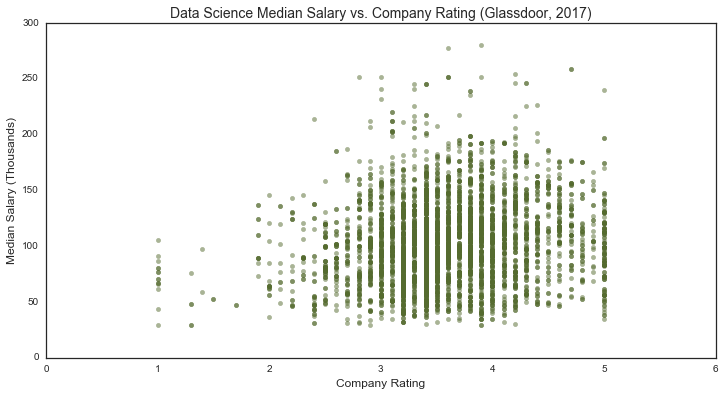

In [43]:
plt.figure(figsize=(12,6))
plt.scatter(df['rating'], df['median_salary'],alpha=0.5,color='darkolivegreen')
plt.title('Data Science Median Salary vs. Company Rating (Glassdoor, 2017)', fontsize=14)
plt.ylabel('Median Salary (Thousands)', fontsize=12)
plt.xlabel('Company Rating', fontsize=12)
plt.show()

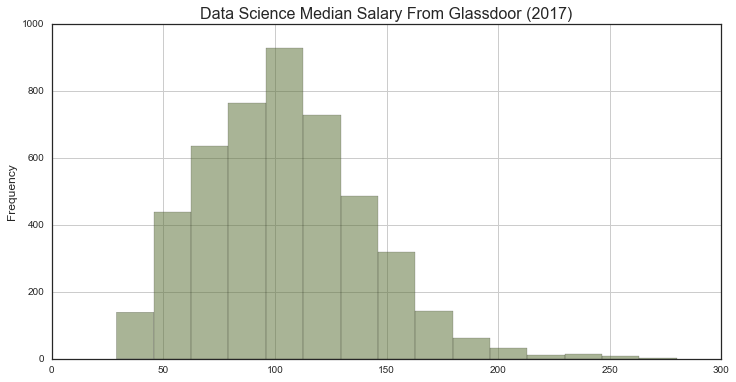

In [44]:
df['median_salary'].hist(bins=15,figsize=(12,6),alpha = 0.5, color = 'darkolivegreen')
plt.xlabel('', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Data Science Median Salary From Glassdoor (2017)', fontsize=16);

#### Modeling

In [45]:
# sns.heatmap(df1)

<font face="Courier">
<b> Grid Search Logistic Regression 

In [46]:
# binary median salary for high or low results 

df1['binary_salary'] = pd.qcut(df['median_salary'],2,labels=[0,1],precision=0)

In [47]:
X_features = df1.ix[:,1:-1]
y_target = df1['binary_salary']

In [48]:
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, .1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 10.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals},\
                  verbose=False, cv=30)
gs.fit(X_features, y_target)

GridSearchCV(cv=30, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [49]:
# best paremater 
gs.best_params_

{'C': 0.005, 'penalty': 'l1'}

In [50]:
logreg = LogisticRegression(C=gs.best_params_['C'],\
                            penalty=gs.best_params_['penalty'])


In [51]:
cross_val_score(logreg, X_features, y_target, n_jobs=1, cv=30).mean()

0.68879067374794212

In [52]:
cv_model = logreg.fit(X_features, y_target)
feature_rank = pd.concat([pd.DataFrame(X_features.columns).T,pd.DataFrame(abs(cv_model.coef_))], axis =0).T
feature_rank.columns = ['feature','coef']
feature_rank.sort('coef',ascending=False)

/Users/erikahuerta/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,coef
1,data_scientist,0.675982
0,rating,0.0610955
175,state_VA,0
120,city_Redondo Beach,0
112,city_Oakland,0
113,city_Palo Alto,0
114,city_Pasadena,0
115,city_Playa Vista,0
116,city_Playa del Rey,0
117,city_Pleasanton,0
